The goal is modeling a scenario in which a seller exploits advertising tools to attract more and more users to its website, thus increasing the number of possible buyers. The seller needs to learn simultaneously the conversion rate and the number of users the advertising tools can attract.

1) Imagine:
    - one product to sell;
    - three classes of users, where, for every user, we can observe the values of two binary features (feel free to choose the features and their domains);
    - the conversion rate curve of each class of users;
    - three subcampaigns, each with a different ad, to advertise the product, and each targeting a different class of users;
    - there are three abrupt phases;
    - for every abrupt phase and for every subcampaign, the probability distribution over the daily number of clicks for every value of budget allocated to that subcampaign.

3) Design a sliding-window combinatorial bandit algorithm for the case, instead, in which there are the three phases aforementioned.
Plot the cumulative regret and compare it with the cumulative regret that a non-sliding-window algorithm would obtain.


9 curve, 3 fasi

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from project.Urbano08.AbruptBiddingEnvironment import AbruptBiddingEnvironment
from project.Urbano08.DynamicLearner import DynamicLearner
from project.Urbano08.Learner import Learner
from project.Urbano08.Optimizer import Optimizer as Ta, Optimizer
import pandas as pd

In [2]:
n_phases = 3
len_window = 40
phaselen = 60
n_obs = 180 #3 abrupt phase
print_span = 60 #ogni quanti giorni printare i grafici

init_days = 20 #primi giorni si pullano gli arm in modo casuale senza pensare al reward massimo
random_sampling = 5

n_subcamp = 3

max_bid = 1
max_clicks = 100
n_arms = 11

noise_std = 5.0

bids = np.linspace(0, max_bid, n_arms)

In [3]:
sw_total_click_each_day  = pd.DataFrame(columns=['bid_sub1', 'bid_sub2', 'bid_sub3',"click1","click2","click3"])


env = AbruptBiddingEnvironment(bids,max_clicks,noise_std,phaselen, n_phases)

sw_learners = []


for i in range(0, n_subcamp):
    sw_learners.append(DynamicLearner(n_arms,bids,len_window))

print(f'PHASES OF {env.phaselen} DAYS\n{n_obs} TOTAL OBSERVATION')



for d in range(0, n_obs):
    pulled = [0,0,0]
    #per i primi init_days giorni si pullano in modo causale, successivamente si usa la tabella
    if init_days > 0: #or d % random_sampling == 0: #or d % int(len_window/2) == 0:
        init_days = init_days - 1
        first = d % 3
        pulled[first] = sw_learners[first].pull_arm()
        pulled[(first + 1 )% 3] = np.random.randint(0,n_arms - pulled[first])
        pulled[(first + 2 )% 3] = n_arms - pulled[first] - pulled[(first + 1 )% 3] - 1
    else:
        #uso l'algoritmo della tabella per selezionare gli arm che mi danno un reward massimo
        table_all_Subs = np.ndarray(shape=(0,len(bids)), dtype=float)
        for l in sw_learners:
            table_all_Subs = np.append(table_all_Subs,np.atleast_2d(l.means.T),0)
        pulled = Ta.fit_table(table_all_Subs)[0]


    clicks = env.round(pulled[0],pulled[1],pulled[2])


    for x in range(0,n_subcamp):
        sw_learners[x].update(pulled[x], clicks[x])
    sw_total_click_each_day = sw_total_click_each_day.append({
        'bid_sub1':pulled[0],
        'bid_sub2':pulled[1],
        'bid_sub3':pulled[2],
        "click1":clicks[0],
        "click2":clicks[1],
        "click3":clicks[2]
    }, ignore_index=True)

    if (d+1) % print_span == 0:
        #TIME TO PRINT THE PLOTS
        print(f"DAY: {d}\nPULLED:{pulled}\nCLICKS: {clicks}\nTOT: {clicks.sum()}\n")

        #for l in range(0,len(learners)):
            #learners[l].plot(env.subs[l])

PHASES OF 60 DAYS
180 TOTAL OBSERVATION
DAY: 59
PULLED:[5, 0, 5]
CLICKS: [ 86.54960105   0.         101.93725071]
TOT: 188.48685176171898

DAY: 119
PULLED:[3, 2, 5]
CLICKS: [101.19811522  11.47833302  37.59575171]
TOT: 150.27219995001317

DAY: 179
PULLED:[8, 2, 0]
CLICKS: [105.5433744   37.54174413   0.        ]
TOT: 143.08511853978598



In [4]:
total_click_each_day  = pd.DataFrame(columns=['bid_sub1', 'bid_sub2', 'bid_sub3',"click1","click2","click3"])
env = AbruptBiddingEnvironment(bids,max_clicks,noise_std,phaselen, n_phases)
init_days = 20
learners = []

for i in range(0, n_subcamp):
    learners.append(Learner(n_arms,bids))

for d in range(0, n_obs):
    pulled = [0,0,0]
    #per i primi init_days giorni si pullano in modo causale, successivamente si usa la tabella
    if init_days > 0 or d % random_sampling == 0: #or d % int(len_window/2) == 0:
        init_days = init_days - 1
        first = d % 3
        pulled[first] = learners[first].pull_arm()
        pulled[(first + 1 )% 3] = np.random.randint(0,n_arms - pulled[first])
        pulled[(first + 2 )% 3] = n_arms - pulled[first] - pulled[(first + 1 )% 3] - 1
    else:
        #uso l'algoritmo della tabella per selezionare gli arm che mi danno un reward massimo
        table_all_Subs = np.ndarray(shape=(0,len(bids)), dtype=float)
        for l in learners:
            table_all_Subs = np.append(table_all_Subs,np.atleast_2d(l.means.T),0)
        pulled = Ta.fit_table(table_all_Subs)[0]


    clicks = env.round(pulled[0],pulled[1],pulled[2])


    for x in range(0,n_subcamp):
        learners[x].update(pulled[x], clicks[x])
    total_click_each_day = total_click_each_day.append({
        'bid_sub1':pulled[0],
        'bid_sub2':pulled[1],
        'bid_sub3':pulled[2],
        "click1":clicks[0],
        "click2":clicks[1],
        "click3":clicks[2]
    }, ignore_index=True)

    if (d+1) % print_span == 0:
        #TIME TO PRINT THE PLOTS
        print(f"DAY: {d}\nPULLED:{pulled}\nCLICKS: {clicks}\nTOT: {clicks.sum()}\n")




DAY: 59
PULLED:[6, 0, 4]
CLICKS: [85.43769035  0.         95.35478623]
TOT: 180.79247657822555

DAY: 119
PULLED:[4, 1, 5]
CLICKS: [96.82463308  0.50444016 37.23456315]
TOT: 134.56363639340265

DAY: 179
PULLED:[3, 2, 5]
CLICKS: [91.95489272 26.13336757  0.        ]
TOT: 118.0882602944703



189.09664078218532
164.1044269039987
168.6197523318644


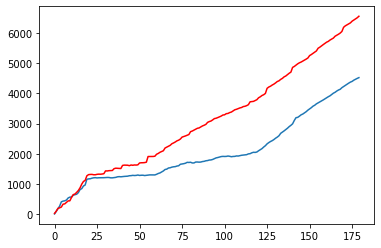

In [5]:
clicks_opt = np.array([])

for p in range(0,n_phases):
    all_optimal_subs = np.ndarray(shape=(0,len(bids)), dtype=float)
    for i in range(0,n_subcamp):
        all_optimal_subs = np.append(all_optimal_subs,np.atleast_2d(env.subs[i](bids,p)),0)
    opt = Optimizer.fit_table(all_optimal_subs)[1]
    print(opt)
    for days in range(0,phaselen):
        clicks_opt = np.append(clicks_opt, opt)




sw_clicks_obtained = sw_total_click_each_day["click1"] + \
                  sw_total_click_each_day["click2"] + \
                  sw_total_click_each_day["click3"]

clicks_obtained = total_click_each_day["click1"] + \
                  total_click_each_day["click2"] + \
                  total_click_each_day["click3"]


np.cumsum(clicks_opt - sw_clicks_obtained).plot()
np.cumsum(clicks_opt - clicks_obtained).plot(color="red")
plt.show()


In [6]:
print(sum(sw_total_click_each_day["click1"] + \
                  sw_total_click_each_day["click2"] + \
                  sw_total_click_each_day["click3"]))

print(sum(total_click_each_day["click1"] + \
                  total_click_each_day["click2"] + \
                  total_click_each_day["click3"]))

26790.74979982143
24762.66430973179


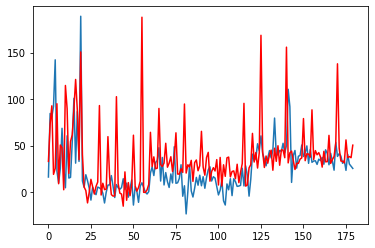

In [7]:
(clicks_opt - sw_clicks_obtained).plot()
(clicks_opt - clicks_obtained).plot(color="red")
plt.show()